<a href="https://colab.research.google.com/github/DIPANJAN001/Forecasting-Solar-Energy/blob/master/optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install Boruta
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import concatenate
from keras import Model
from keras.layers import Input
from keras.layers import Bidirectional
from keras import layers
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import LeakyReLU
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.models import load_model
from keras.layers import Input
from sklearn.decomposition import PCA 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 KB 2.3 MB/s eta 0:00:00


In [2]:
def lstm_data_transform(x_data, y_data, num_steps):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [3]:
df=pd.read_excel("/content/pv_04.xlsx")
weather_input1=df.drop('power_normed',axis=1)
weather_input=weather_input1.drop('time_idx',axis=1)
solpow=df['power_normed']

In [4]:
rfc = RandomForestRegressor(random_state=1, n_estimators=1000, max_depth=5)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=1)
boruta_selector.fit(np.array(weather_input), np.array(solpow)) 

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	17
Rejected: 	23
Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	17
Rejected: 	23
Iteration: 	10 / 100
Confirmed: 	9
Tentative: 	17
Rejected: 	23
Iteration: 	11 / 100
Confirmed: 	9
Tentative: 	17
Rejected: 	23
Iteration: 	12 / 100
Confirmed: 	10
Tentative: 	16
Rejected: 	23
Iteration: 	13 / 100
Confirmed: 	10
Tentative: 	16
Rejected: 	23
Iteration: 	14 / 100
Confirmed: 	10
Tentative: 	16
Rejected: 	23
Iteration: 	15 / 100
Confirmed: 	10
Tentative: 	16
Rejected: 	23
Iteration: 	16 / 100
Confirmed: 	11
Tentative: 	15
R

BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=141,
                                         random_state=RandomState(MT19937) at 0x7F18596B3240),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F18596B3240, verbose=2)

In [5]:
X_important_train = boruta_selector.transform(np.array(weather_input))
num_steps = 2
# training set
(x_transformed_train,
 y_transformed_train) = lstm_data_transform(X_important_train,solpow , num_steps=num_steps)
assert x_transformed_train.shape[0] == y_transformed_train.shape[0]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_transformed_train,y_transformed_train,test_size=0.33, random_state=42,shuffle=False)
#X_train_,X_val,y_train_,y_val=train_test_split(X_train,y_train,test_size=0.2, random_state=42,shuffle=False)
inputs1 = Input(shape=(X_train.shape[1],X_train.shape[2]))

In [6]:
inputs1

<KerasTensor: shape=(None, 2, 18) dtype=float32 (created by layer 'input_1')>

In [7]:
from keras import optimizers

In [8]:
from keras.optimizers import Adam
from keras import backend as K
import numpy as np

class RandomRestartAdam(Adam):
    def __init__(self, num_restarts=10, num_steps=100, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=1e-8, decay=0., amsgrad=False, noise_std=0.1, **kwargs):
        super(RandomRestartAdam, self).__init__(lr, beta_1, beta_2, epsilon, decay, amsgrad, **kwargs)
        self.num_restarts = num_restarts
        self.num_steps = num_steps
        self.noise_std = noise_std
        self.best_loss = np.inf
        self.best_weights = None

    def get_weights(self):
        return self.best_weights

    def set_weights(self, weights):
        self.best_weights = weights

    def on_train_begin(self, logs=None):
        self.best_loss = np.inf

    def on_batch_end(self, batch, logs=None):
        current_loss = logs.get('loss')
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.num_restarts == 0 and epoch > 0:
            for _ in range(self.num_steps):
                self.model.fit(self.model.train_on_batch, epochs=1, verbose=0)
                current_loss = logs.get('loss')
                if current_loss < self.best_loss:
                    self.best_loss = current_loss
                    self.best_weights = self.model.get_weights()
            if self.noise_std != 0:
                noise = K.random_normal(shape=K.shape(self.best_weights), mean=0., stddev=self.noise_std)
                self.best_weights = [w + n for w, n in zip(self.best_weights, noise)]
            self.model.set_weights(self.best_weights)


In [ ]:
opt=optimizers.AdamW(learning_rate=0.001)

Epoch 1/200
51/51 [==============================] - 11s 42ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 2/200
51/51 [==============================] - 1s 23ms/step - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 3/200
51/51 [==============================] - 1s 24ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 4/200
51/51 [==============================] - 1s 24ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 5/200
51/51 [==============================] - 1s 24ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 6/200
51/51 [==============================] - 1s 23ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 7/200
51/51 [==============================] - 1s 24ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 8/200
51/51 [==============================] - 1s 24ms/step - loss: 0

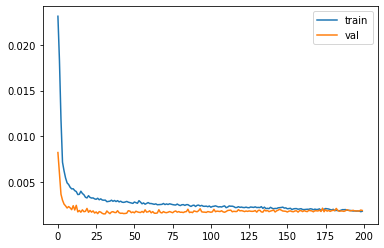

63/63 [==============================] - 1s 4ms/step


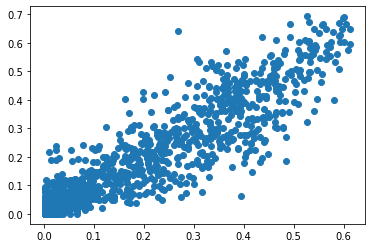

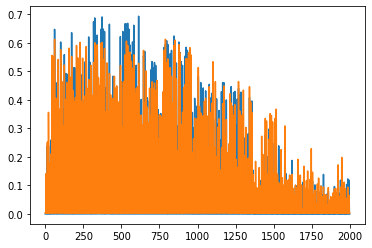

0.056044716362382


In [ ]:
def define_model():


  # firs
  fe1_0 = LSTM(208, activation='relu',return_sequences = True)(inputs1)
  fe1_1 = Dropout(0.5)(fe1_0)
  fe1_2 = LSTM(24, activation='relu',return_sequences = True)(fe1_1)
  fe1_3= Dropout(0.2)(fe1_2)
  fe1_4=LSTM(30, activation='relu')(fe1_3)
  out1_1=Dense(1, activation='relu')(fe1_4)



  fe2_0 = LSTM(208, activation='relu',return_sequences = True)(inputs1)
  fe2_1 = Dropout(0.6)(fe2_0)
  fe2_2 = LSTM(60, activation='relu',return_sequences = True)(fe2_1)
  fe2_3= Dropout(0.5)(fe2_2)
  fe2_4=LSTM(4, activation='relu')(fe2_3)
  out2_1=Dense(1, activation='relu')(fe2_4)

  fe3_0 =LSTM(104, activation='relu',return_sequences = True)(inputs1)
  fe3_1 = Dropout(0.6)(fe3_0)
  fe3_2 = LSTM(96, activation='relu',return_sequences = True)(fe3_1)
  fe3_3= Dropout(0.5)(fe3_2)
  fe3_4=LSTM(8, activation='relu')(fe3_3)#16
  out3_1=Dense(1, activation='relu')(fe3_4)
 
 

  #output = layers.average([ out1_1, out2_1, out3_1])
  merged3 = concatenate([out1_1,out2_1,out3_1], name='concat3')
  output = Dense(1, activation='relu')( merged3)
  

  model = Model(inputs=[inputs1], outputs=[output])
  model.compile(optimizer=opt,loss='mean_squared_error',metrics=['mse'])
 
  return model
mdl=define_model()
history=mdl.fit(X_train, y_train, epochs = 200,validation_split=0.2,batch_size =64)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
y=mdl.predict(X_test)
plt.scatter(y,y_test)
plt.show()
df = pd.DataFrame()
df['time']=[i for i in range(len(y))]
df['Actual']=y_test
df['Predicted']=y
plt.plot(df['time'],df['Actual'])
plt.plot(df['time'],df['Predicted'])
plt.show()
print(np.sqrt(mean_squared_error(y,y_test)))

Epoch 1/200
51/51 [==============================] - 10s 43ms/step - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 2/200
51/51 [==============================] - 1s 23ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 3/200
51/51 [==============================] - 1s 23ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 4/200
51/51 [==============================] - 1s 23ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 5/200
51/51 [==============================] - 1s 24ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 6/200
51/51 [==============================] - 1s 24ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 7/200
51/51 [==============================] - 1s 22ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 8/200
51/51 [==============================] - 1s 23ms/step - loss: 0

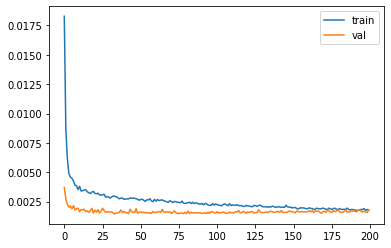

63/63 [==============================] - 1s 4ms/step


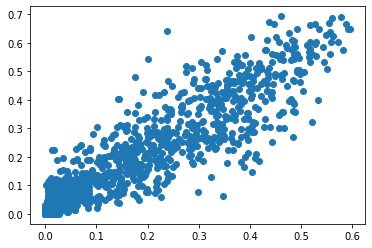

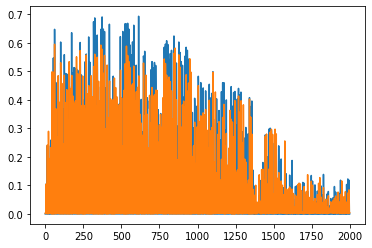

0.058634311882956015


In [ ]:
def define_model():


  # firs
  fe1_0 = LSTM(208, activation='relu',return_sequences = True)(inputs1)
  fe1_1 = Dropout(0.5)(fe1_0)
  fe1_2 = LSTM(24, activation='relu',return_sequences = True)(fe1_1)
  fe1_3= Dropout(0.5)(fe1_2)
  fe1_4=LSTM(30, activation='relu')(fe1_3)
  out1_1=Dense(1, activation='relu')(fe1_4)



  fe2_0 = LSTM(208, activation='relu',return_sequences = True)(inputs1)
  fe2_1 = Dropout(0.5)(fe2_0)
  fe2_2 = LSTM(60, activation='relu',return_sequences = True)(fe2_1)
  fe2_3= Dropout(0.5)(fe2_2)
  fe2_4=LSTM(4, activation='relu')(fe2_3)
  out2_1=Dense(1, activation='relu')(fe2_4)

  fe3_0 =LSTM(104, activation='relu',return_sequences = True)(inputs1)
  fe3_1 = Dropout(0.6)(fe3_0)
  fe3_2 = LSTM(96, activation='relu',return_sequences = True)(fe3_1)
  fe3_3= Dropout(0.5)(fe3_2)
  fe3_4=LSTM(8, activation='relu')(fe3_3)#16
  out3_1=Dense(1, activation='relu')(fe3_4)
 
 

  output = layers.average([ out1_1, out2_1, out3_1])
  #merged3 = concatenate([out1_1,out2_1,out3_1], name='concat3')
  
  #output = Dense(1, activation='relu')( merged3)
  

  model = Model(inputs=[inputs1], outputs=[output])
  model.compile(optimizer=opt,loss='mean_squared_error',metrics=['mse'])
 
  return model
mdl=define_model()
history=mdl.fit(X_train, y_train, epochs = 200,validation_split=0.2,batch_size =64 )
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
y=mdl.predict(X_test)
plt.scatter(y,y_test)
plt.show()
df = pd.DataFrame()
df['time']=[i for i in range(len(y))]
df['Actual']=y_test
df['Predicted']=y
plt.plot(df['time'],df['Actual'])
plt.plot(df['time'],df['Predicted'])
plt.show()
print(np.sqrt(mean_squared_error(y,y_test)))

In [ ]:
from keras.layers import Bidirectional

Epoch 1/75
51/51 [==============================] - 32s 143ms/step - loss: 0.0199 - mse: 0.0199 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 2/75
51/51 [==============================] - 4s 86ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 3/75
51/51 [==============================] - 4s 86ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 4/75
51/51 [==============================] - 4s 85ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 5/75
51/51 [==============================] - 4s 86ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 6/75
51/51 [==============================] - 4s 85ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 7/75
51/51 [==============================] - 4s 86ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 8/75
51/51 [==============================] - 4s 86ms/step - loss: 0.0036 -

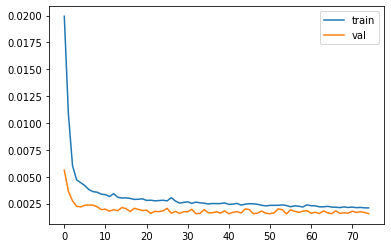

63/63 [==============================] - 4s 16ms/step


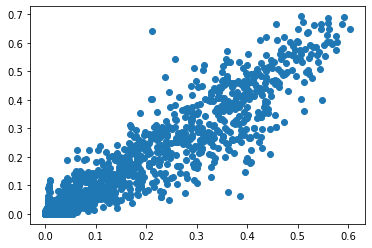

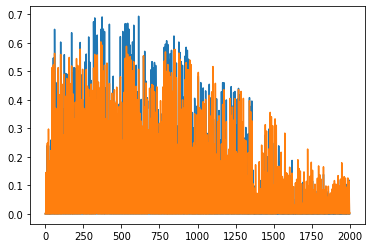

0.05350192207793522


In [9]:
def define_model():


  # firs
  fe1_0 = Bidirectional(LSTM(208, activation='relu',return_sequences = True))(inputs1)
  fe1_1 = Dropout(0.5)(fe1_0)
  fe1_2 = Bidirectional(LSTM(24, activation='relu',return_sequences = True))(fe1_1)
  fe1_3= Dropout(0.2)(fe1_2)
  fe1_4=Bidirectional(LSTM(30, activation='relu'))(fe1_3)
  out1_1=Dense(1, activation='relu')(fe1_4)



  fe2_0 = Bidirectional(LSTM(208, activation='relu',return_sequences = True))(inputs1)
  fe2_1 = Dropout(0.6)(fe2_0)
  fe2_2 = Bidirectional(LSTM(60, activation='relu',return_sequences = True))(fe2_1)
  fe2_3= Dropout(0.5)(fe2_2)
  fe2_4=Bidirectional(LSTM(4, activation='relu'))(fe2_3)
  out2_1=Dense(1, activation='relu')(fe2_4)

  fe3_0 =Bidirectional(LSTM(104, activation='relu',return_sequences = True))(inputs1)
  fe3_1 = Dropout(0.6)(fe3_0)
  fe3_2 = Bidirectional(LSTM(96, activation='relu',return_sequences = True))(fe3_1)
  fe3_3= Dropout(0.5)(fe3_2)
  fe3_4=Bidirectional(LSTM(8, activation='relu'))(fe3_3)#16
  out3_1=Dense(1, activation='relu')(fe3_4)
 
 

  output = layers.average([ out1_1, out2_1, out3_1])
  #merged3 = concatenate([out1_1,out2_1,out3_1], name='concat3')
  #output = Dense(1, activation='relu')( merged3)
  

  model = Model(inputs=[inputs1], outputs=[output])
  model.compile(optimizer=RandomRestartAdam(),loss='mean_squared_error',metrics=['mse'])
 
  return model
mdl=define_model()
history=mdl.fit(X_train, y_train, epochs = 75,validation_split=0.2,batch_size =64)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
y=mdl.predict(X_test)
plt.scatter(y,y_test)
plt.show()
df = pd.DataFrame()
df['time']=[i for i in range(len(y))]
df['Actual']=y_test
df['Predicted']=y
plt.plot(df['time'],df['Actual'])
plt.plot(df['time'],df['Predicted'])
plt.show()
print(np.sqrt(mean_squared_error(y,y_test)))

Epoch 1/75
51/51 [==============================] - 21s 85ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 2/75
51/51 [==============================] - 2s 48ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 3/75
51/51 [==============================] - 2s 48ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 4/75
51/51 [==============================] - 3s 49ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 5/75
51/51 [==============================] - 3s 50ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 6/75
51/51 [==============================] - 3s 50ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 7/75
51/51 [==============================] - 2s 48ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 8/75
51/51 [==============================] - 2s 48ms/step - loss: 0.0034 - 

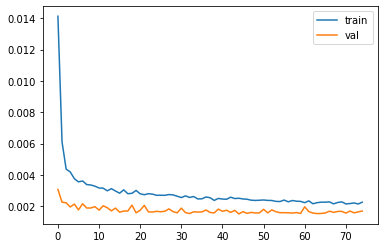

63/63 [==============================] - 2s 8ms/step


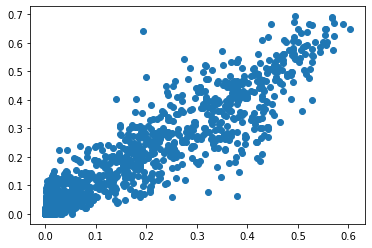

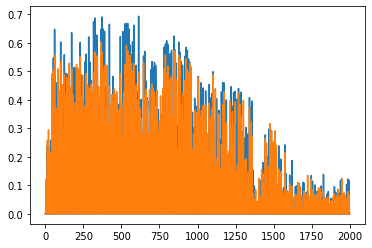

0.05556552171034254


In [ ]:
def define_model():


  # firs
  fe1_0 = Bidirectional(LSTM(208, activation='relu',return_sequences = True))(inputs1)
  fe1_1 = Dropout(0.5)(fe1_0)
  fe1_2 = Bidirectional(LSTM(24, activation='relu',return_sequences = True))(fe1_1)
  fe1_3= Dropout(0.2)(fe1_2)
  fe1_4=Bidirectional(LSTM(30, activation='relu'))(fe1_3)
  out1_1=Dense(1, activation='relu')(fe1_4)



  fe2_0 = Bidirectional(LSTM(208, activation='relu',return_sequences = True))(inputs1)
  fe2_1 = Dropout(0.6)(fe2_0)
  fe2_2 = Bidirectional(LSTM(60, activation='relu',return_sequences = True))(fe2_1)
  fe2_3= Dropout(0.5)(fe2_2)
  fe2_4=Bidirectional(LSTM(4, activation='relu'))(fe2_3)
  out2_1=Dense(1, activation='relu')(fe2_4)

  fe3_0 =Bidirectional(LSTM(104, activation='relu',return_sequences = True))(inputs1)
  fe3_1 = Dropout(0.6)(fe3_0)
  fe3_2 = Bidirectional(LSTM(96, activation='relu',return_sequences = True))(fe3_1)
  fe3_3= Dropout(0.5)(fe3_2)
  fe3_4=Bidirectional(LSTM(8, activation='relu'))(fe3_3)#16
  out3_1=Dense(1, activation='relu')(fe3_4)
 
 

  #output = layers.average([ out1_1, out2_1, out3_1])
  merged3 = concatenate([out1_1,out2_1,out3_1], name='concat3')
  output = Dense(1, activation='relu')( merged3)
  

  model = Model(inputs=[inputs1], outputs=[output])
  model.compile(optimizer=opt,loss='mean_squared_error',metrics=['mse'])
 
  return model
mdl=define_model()
history=mdl.fit(X_train, y_train, epochs = 75,validation_split=0.2,batch_size =64)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
y=mdl.predict(X_test)
plt.scatter(y,y_test)
plt.show()
df = pd.DataFrame()
df['time']=[i for i in range(len(y))]
df['Actual']=y_test
df['Predicted']=y
plt.plot(df['time'],df['Actual'])
plt.plot(df['time'],df['Predicted'])
plt.show()
print(np.sqrt(mean_squared_error(y,y_test)))